<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_2_yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Natural Language Processing and Sentiment Analysis for Yelp**

Explore Starbucks review in New York City

In [0]:
import pandas as pd
import requests
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#client_id = 'NTXTygLQ8Y5baxwIGObaJA' 
#key = 'V28EIFx3cLv9o7-oZfNIrwi7dw3cmEW8DVWOU1HKdhDMjZhlhMvmGKe8C3P0Ohwxi31DbZrVlZSa2CdodvGKMddaopwFOv8TUdymcROofzsIfYZbj21IFCWNiB2JXHYx'

# get yelp api (https://www.yelp.com/developers)
# 

client_id = 'fl6Gc_WOT5VLrae0o6fc7w' 
key = 'kArR8ttjf4JdZDtC27-InwcgepdkWrtTcSfaHKwf_JMtQY0LvXgfaG3lmUA3F2oCCp-KUa-W8tPuVXdm8Abwj6N0m0YJniJHVa61rXEFMLuAM11d2IrYSV5NEYGJXHYx'

ENDPOINT = 'https://api.yelp.com/v3/businesses/search'

HEADERS = {'Authorization':'bearer {}'.format(key)}

PARAMETERS = {#'term':'restaurant'or "food"  ,
             'term' : 'Starbucks',
              'limit':50,
             'radius':20000, # meter
              #'sort_by' :'review_count', 
             'location':"NYC"
             }

response = requests.get(url = ENDPOINT, params = PARAMETERS, headers = HEADERS)

read data (json) 

In [0]:
data = response.json()

In [59]:
data["businesses"][1]

{'alias': 'starbucks-brooklyn-21',
 'categories': [{'alias': 'coffee', 'title': 'Coffee & Tea'}],
 'coordinates': {'latitude': 40.702668, 'longitude': -73.990806294802},
 'display_phone': '(718) 855-0856',
 'distance': 426.3054744805125,
 'id': 'qcnoyytlFIuqlcjDXkXJiw',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/cTvcr7PmCfAWs01sLr-E3A/o.jpg',
 'is_closed': False,
 'location': {'address1': '67 Front Street',
  'address2': '',
  'address3': '',
  'city': 'Brooklyn',
  'country': 'US',
  'display_address': ['67 Front Street', 'Brooklyn, NY 11201'],
  'state': 'NY',
  'zip_code': '11201'},
 'name': 'Starbucks',
 'phone': '+17188550856',
 'price': '$$',
 'rating': 2.5,
 'review_count': 62,
 'transactions': [],
 'url': 'https://www.yelp.com/biz/starbucks-brooklyn-21?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=fl6Gc_WOT5VLrae0o6fc7w'}

In [60]:
data["businesses"][10]['categories'][2]['title']# info of the business

IndexError: ignored

In [61]:
data["businesses"][0]['id'] # parse id for review (with highest review count)

'xAvwjM0F5LN9g3yFsk9e0w'

read review of this businesses of the highest review count

In [0]:
ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/xAvwjM0F5LN9g3yFsk9e0w/reviews'   # id/reviews  
response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)

In [85]:
response_reviews.json()['reviews'][2]#['user']['profile_url']

{'id': 'kQgAMxZ8QnR2QBasRGhf1Q',
 'rating': 1,
 'text': "I ordered a frap grande at about 630am. Terrible customer service. The person that took my order tells her co worker that she doesn't know how to make the...",
 'time_created': '2018-10-29 04:32:36',
 'url': 'https://www.yelp.com/biz/starbucks-new-york-128?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=kQgAMxZ8QnR2QBasRGhf1Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w',
 'user': {'id': '80C0TcovjunD9hr6loBujg',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/f9ZHThG7eSjFsEzwuoYOPQ/o.jpg',
  'name': 'Chris T.',
  'profile_url': 'https://www.yelp.com/user_details?userid=80C0TcovjunD9hr6loBujg'}}

In [43]:
len(response_reviews.json())

3

In [44]:
response_reviews.text

'{"reviews": [{"id": "UmxqFImoe3N-aT2RAimHCw", "url": "https://www.yelp.com/biz/starbucks-brooklyn-54?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=UmxqFImoe3N-aT2RAimHCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w", "text": "There\'s not really much you can say about Starbucks coffee or food other than that it\'s usually good despite of where you are. What I can say about this...", "rating": 4, "time_created": "2018-12-19 15:41:36", "user": {"id": "y6pqwNJzRbC8iqBQvLbiXQ", "profile_url": "https://www.yelp.com/user_details?userid=y6pqwNJzRbC8iqBQvLbiXQ", "image_url": "https://s3-media1.fl.yelpcdn.com/photo/628D_JGWn5mvAlelCTsyvQ/o.jpg", "name": "Shantee E."}}, {"id": "KO0ty3kRBuSmYe0TkB49eQ", "url": "https://www.yelp.com/biz/starbucks-brooklyn-54?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=KO0ty3kRBuSmYe0TkB49eQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w", "text": "Even though these photo

Next, we can make a list of the businesses with their id, rating, and price

In [0]:
# list of id in businesses with rating
list_buss = []
#i = 0s
for item in data['businesses']:
  #print(i)
  #i+= 1
  try:
    list_buss.append([item['id'], item['rating'], item['price'],item['review_count']])#, \
  except:
    list_buss.append([item['id'], item['rating'], None, None])
    #pass
  #print(item['id'])
#list_buss

In [66]:
len(list_buss)

50

In [67]:
# convert to pandas format
#list_buss = pd.DataFrame(list_buss, columns = ['id','rating','price', 'count', 'alitas1', 'alitas2', 'alitas3','title1',\
#'title2','title3'])
list_buss = pd.DataFrame(list_buss, columns = ['id','rating','price', 'count'])

list_buss.head()

,id,rating,price,count
0,xAvwjM0F5LN9g3yFsk9e0w,4.0,$$,7.0
1,qcnoyytlFIuqlcjDXkXJiw,2.5,$$,62.0
2,60agfQbky4cX8BEApyltIA,2.0,$,22.0
3,VGMdcAn34GeasB4arA8XUA,3.0,$,35.0
4,_H9AnQkr5VtOiykNnxcQlQ,2.5,$$,23.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe68e9e3b70>,
      dtype=object)

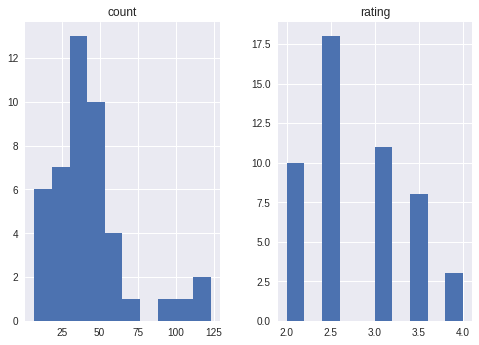

In [68]:
list_buss.hist()

In [69]:
list_buss.groupby('price').count()

,id,rating,count
price,,,
$,12,12,12
$$,33,33,33


In [70]:
high_rating = list_buss[list_buss['rating']>=3.0]
high_rating.groupby('rating').count()

,id,price,count
rating,,,
3.0,11,10,10
3.5,8,7,7
4.0,3,1,1


In [71]:
low_rating = list_buss[list_buss['rating']<3.0]
low_rating.groupby('rating').count()

,id,price,count
rating,,,
2.0,10,10,10
2.5,18,17,17


In [0]:
# colect review
List_HR_review = []
List_HR_rating = []
for i in range(50):

  try:
    ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/'+ high_rating['id'][i] +'/reviews'
    response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)
    for ii in range(3):

      x = response_reviews.json()['reviews'][ii]['text']
      List_HR_review.append(x)
      y = response_reviews.json()['reviews'][ii]['rating']
      List_HR_rating.append(y)
  except:
    pass

In [135]:
List_HR_review_pd = pd.DataFrame(List_HR_review, columns =['review'])
#len(List_reiew_all_pd)
List_HR_review_pd.head()

,review
0,There's not really much you can say about Star...
1,Even though these photos are completely unreal...
2,"It really doesn't matter what you get here, it..."
3,Hot tip! There's seating upstairs!!!\nI lived ...
4,Friendly staff. Helped me streamline my otherw...


In [136]:
high_rating['id']

0     xAvwjM0F5LN9g3yFsk9e0w
3     VGMdcAn34GeasB4arA8XUA
6     OuNYQaqEJjkBHRdnC-4HOw
7     mEMPhPK6dSgy5eXS-kYHLg
8     7AlGQ0kJgYFz3xCW_rj2LQ
10    pTv4RDll3N_CGG3BwtEctg
11    j6nTfbYavGVsJKxz6bte6w
20    p8Fygzdm1uONUTu4q-SfJA
21    FrigBgxfxMxwPJNq-hAr0Q
26    RIklVZ2AEvC62MtCPRmFRQ
29    OQEU7KPvgDX9kX2xlHGm5g
31    JXKpCS9Ru3nt7U0_kFqZgA
32    rPXlTqHLYKcXyADOeqzwbg
35    01cAFjVfryumdxZCs-QG-A
36    iWoOAvIYqZ8nqx1BYcuZYw
41    5mg6AXDk_j_RAlKvGIyROQ
42    wE3_AwZoZ0ZXbngBH1xRrg
44    gfDj7Aa8U9K5UkJ9H65N3w
45    MMw3oR3cDbtUkvs78xD00Q
46    AvpB-RQgEW9N4Eip3l3cww
47    mQWt-66AkXyTrRNFElmFMw
49    a2nfVfbuobr5EX6sDH7jyw
Name: id, dtype: object

In [137]:
print(len(high_rating))
print(len(List_HR_review))
print(len(List_HR_rating))

22
64
64


In [0]:
# colect review
List_LR_review = []
List_LR_rating = []
for i in range(50):
  #print(i)
  try:
    ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/'+ low_rating['id'][i] +'/reviews'
    response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)
    for ii in range(2):
      x = response_reviews.json()['reviews'][ii]['text']
      List_LR_review.append(x)
      y = response_reviews.json()['reviews'][ii]['rating']
      List_LR_rating.append(y)
  except:
    pass

In [142]:
List_LR_review_pd = pd.DataFrame(List_LR_review, columns =['review'])

56

In [145]:
print(len(low_rating))
print(len(List_LR_review))
print(len(List_LR_rating))

28
56
56


In [151]:
d = {'rate': List_HR_rating, 'review': List_HR_review}
df_HR = pd.DataFrame(data=d)
df_HR.head()

,rate,review
0,4,There's not really much you can say about Star...
1,4,Even though these photos are completely unreal...
2,5,"It really doesn't matter what you get here, it..."
3,4,Hot tip! There's seating upstairs!!!\nI lived ...
4,5,Friendly staff. Helped me streamline my otherw...


In [152]:
d = {'rate': List_LR_rating, 'review': List_LR_review}
df_LR = pd.DataFrame(data=d)
df_LR.head()

,rate,review
0,4,I honestly had a great experience here so I'm ...
1,4,Who doesn't love a Vanilla Chai on a crisp fal...
2,4,"Very clean, spacious, beautiful store.\nFriend..."
3,1,I went back for more punishment. This time I m...
4,4,This starbucks is so efficient! I work a 1-2mi...


In [154]:
df_total = df_HR.append(df_LR)
df_total.head()

,rate,review
0,4,There's not really much you can say about Star...
1,4,Even though these photos are completely unreal...
2,5,"It really doesn't matter what you get here, it..."
3,4,Hot tip! There's seating upstairs!!!\nI lived ...
4,5,Friendly staff. Helped me streamline my otherw...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe68e888518>]],
      dtype=object)

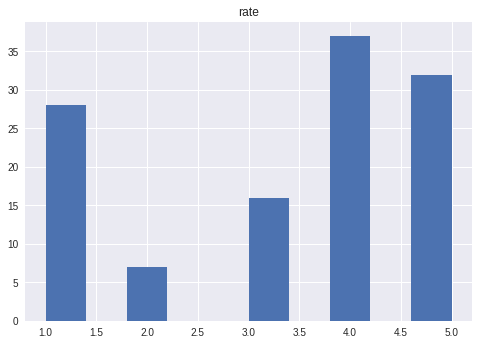

In [155]:
df_total.hist()

In [0]:
df_total['Polarity'] = [TextBlob(x).sentiment[0] for x in df_total['review'] ]
df_total['Subjectivity'] = [TextBlob(x).sentiment[1] for x in df_total['review'] ]

In [163]:
df_total_HR = df_total[df_total['rate']>=4]
df_total_LR = df_total[df_total['rate']<4]

print(len(df_total_HR))
print(len(df_total_LR))

69
51


In [165]:
df_total_HR.head()

,rate,review,Polarity,Subjectivity
0,4,There's not really much you can say about Star...,0.158333,0.391667
1,4,Even though these photos are completely unreal...,0.185417,0.675000
2,5,"It really doesn't matter what you get here, it...",0.600000,0.600000
3,4,Hot tip! There's seating upstairs!!!\nI lived ...,0.270117,0.350000
4,5,Friendly staff. Helped me streamline my otherw...,-0.007500,0.575000


In [166]:
df_total_LR.head()

,rate,review,Polarity,Subjectivity
5,2,I can tell you why this starbucks gets a bad r...,-0.350000,0.383333
7,2,Starbucks has never been my favorite Java plac...,0.191071,0.592857
8,1,The cashier cut me off before I finished my or...,-0.125000,0.444444
16,2,Okay this is it. Been here couple of times and...,-0.166667,0.488889
17,3,Located close to City Hall Park and the entran...,0.130000,0.390000


Howis the review rate correlated to the polarity?

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


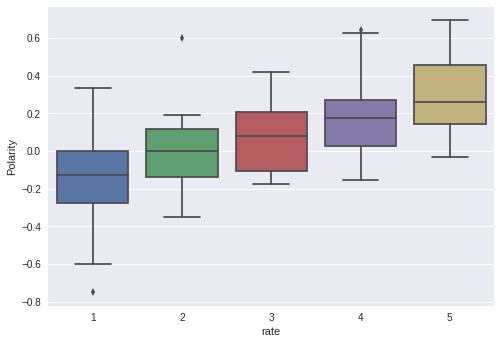

In [175]:
sns.boxplot(x="rate", y="Polarity", data=df_total)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


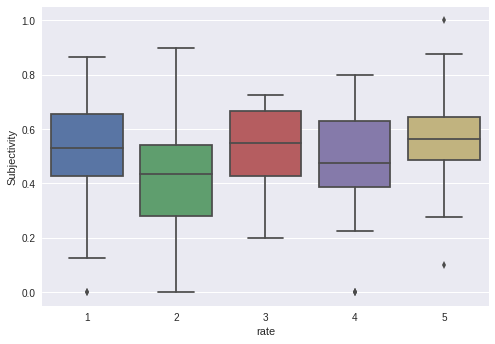

In [176]:
sns.boxplot(x="rate", y="Subjectivity", data=df_total)